# Watershed distance transform for 3-dimensional data

In [1]:
import os
import errno
import argparse

import numpy as np
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras import backend as K

from deepcell import get_data
from deepcell import make_training_data
from deepcell import rate_scheduler
from deepcell.model_zoo import bn_feature_net_3D
from deepcell.model_zoo import bn_feature_net_61x61_3D
from deepcell.model_zoo import dilated_bn_feature_net_61x61_3D
from deepcell.training import train_model_movie
from deepcell.training import train_model_sample_movie
from deepcell.training import train_model_watershed_3D

Using TensorFlow backend.


## Fully Convolutional Training

In [2]:
DATA_OUTPUT_MODE = 'conv'
PADDING = 'same'
RESIZE = False
RESHAPE_SIZE = 256
NUM_FRAMES = 15  # get first N frames from each training folder
BINS = 4  # number of distance bins to classify
EROSION = 0  # number of pixels to erode edges

# filepath constants
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'
PREFIX = 'cells/MouseBrain/generic'
CONV_DATA_FILE = 'MouseBrain_3d_watershed_{}'.format(DATA_OUTPUT_MODE)

# Check for channels_first or channels_last
IS_CHANNELS_FIRST = K.image_data_format() == 'channels_first'

ROW_AXIS = 3 if IS_CHANNELS_FIRST else 2
COL_AXIS = 4 if IS_CHANNELS_FIRST else 3
CHANNEL_AXIS = 1 if IS_CHANNELS_FIRST else 4

# create these directories if they do not exist
for d in (NPZ_DIR, MODEL_DIR, RESULTS_DIR):
    try:
        os.makedirs(os.path.join(d, PREFIX))
        print('Created new directory:', os.path.join(d, PREFIX))
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

In [3]:
# Create the training data
make_training_data(
    dimensionality=3,
    max_training_examples=None,
    direc_name=os.path.join(DATA_DIR, PREFIX),
    file_name_save=os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE),
    channel_names=[''],  # for iterating over stacks of images from a montage
    training_direcs=None,  # all training directories
    output_mode=DATA_OUTPUT_MODE,
    window_size_x=30,
    window_size_y=30,
    window_size_z=3,
    padding=PADDING,
    reshape_size=None if not RESIZE else RESHAPE_SIZE,
    num_frames=NUM_FRAMES,
    montage_mode=True,  # annotation folder has montaged sub-dirs
    annotation_name='',  # basically channel name but for annotated images
    raw_image_direc='stacked_raw_parts',
    annotation_direc='annotated/all_montages')

if os.path.isfile(os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE) + '.npz'):
    print('\nData saved to', os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE) + '.npz')
else:
    raise Exception('Uh Oh!  Your data file did not save properly :(')


Data saved to /data/npz_data/cells/MouseBrain/generic/MouseBrain_3d_watershed_conv.npz


In [4]:
# Load the training data from NPZ into a numpy array
training_data = np.load(os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE + '.npz'))

X, y = training_data['X'], training_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

# Set up training parameters
n_epoch = 32
batch_size = 1
frames_per_batch = 3
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.95)

# save the size of the input data for batch_shape model parameter
size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X.shape[ROW_AXIS:COL_AXIS + 1]
if IS_CHANNELS_FIRST:
    batch_shape = (batch_size, X.shape[CHANNEL_AXIS], frames_per_batch, size[0], size[1])
else:
    batch_shape = (batch_size, frames_per_batch, size[0], size[1], X.shape[CHANNEL_AXIS])

X.shape: (220, 15, 256, 256, 1)
y.shape: (220, 15, 256, 256, 1)


In [5]:
# First, create a foreground/background separation model

# Instantiate the model
fgbg_model = bn_feature_net_3D(
    n_features=2,  # segmentation mask (is_cell, is_not_cell)
    batch_shape=batch_shape,
    norm_method='whole_image')

# Train the model
train_model_movie(
    model=fgbg_model,
    expt='fgbg',
    dataset=CONV_DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    frames_per_batch=frames_per_batch,
    n_epoch=n_epoch,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    lr_sched=rate_scheduler(lr=0.01, decay=0.95),
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (198, 15, 256, 256, 1)
y_train shape: (198, 15, 256, 256, 1)
X_test shape: (22, 15, 256, 256, 1)
y_test shape: (22, 15, 256, 256, 1)
Output Shape: (1, 3, 256, 256, 2)
Number of Classes: 2
Using real-time data augmentation.
Epoch 1/32
989/990 [============================>.] - ETA: 0s - loss: 0.0628 - acc: 0.9156
Epoch 00001: val_loss improved from inf to 0.05972, saving model to /data/models/cells/MouseBrain/generic/2018-08-24_MouseBrain_3d_watershed_conv_fgbg_0.h5
990/990 [==============================] - 245s 248ms/step - loss: 0.0628 - acc: 0.9156 - val_loss: 0.0597 - val_acc: 0.9339
Epoch 2/32
989/990 [============================>.] - ETA: 0s - loss: 0.0574 - acc: 0.9191
Epoch 00002: val_loss improved from 0.05972 to 0.05829, saving model to /data/models/cells/MouseBrain/generic/2018-08-24_MouseBrain_3d_watershed_conv_fgbg_0.h5
990/990 [==============================] - 233s 235ms/step - loss: 0.0574 - acc: 0.9190 - val_loss: 0.0583 - val_acc: 0.9224
Epoch 3/32
989

Epoch 30/32
989/990 [============================>.] - ETA: 0s - loss: 0.0507 - acc: 0.9241
Epoch 00030: val_loss did not improve
990/990 [==============================] - 233s 235ms/step - loss: 0.0507 - acc: 0.9241 - val_loss: 0.0605 - val_acc: 0.9234
Epoch 31/32
989/990 [============================>.] - ETA: 0s - loss: 0.0508 - acc: 0.9240
Epoch 00031: val_loss did not improve
990/990 [==============================] - 232s 235ms/step - loss: 0.0508 - acc: 0.9240 - val_loss: 0.0622 - val_acc: 0.9127
Epoch 32/32
989/990 [============================>.] - ETA: 0s - loss: 0.0509 - acc: 0.9243
Epoch 00032: val_loss did not improve
990/990 [==============================] - 232s 234ms/step - loss: 0.0509 - acc: 0.9243 - val_loss: 0.0588 - val_acc: 0.9292


In [6]:
# Next, Create a model for the watershed energy transform

# Instantiate the model
watershed_model = bn_feature_net_3D(
    n_features=BINS,
    batch_shape=batch_shape,
    norm_method='whole_image')

# Train the model
train_model_watershed_3D(
    model=watershed_model,
    expt='watershed',
    dataset=CONV_DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    n_epoch=n_epoch,
    frames_per_batch=frames_per_batch,
    distance_bins=BINS,
    erosion_width=EROSION,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (198, 15, 256, 256, 1)
y_train shape: (198, 15, 256, 256, 1)
X_test shape: (22, 15, 256, 256, 1)
y_test shape: (22, 15, 256, 256, 1)
Output Shape: (1, 3, 256, 256, 4)
Number of Classes: 4
Using real-time data augmentation.
Epoch 1/32
989/990 [============================>.] - ETA: 0s - loss: 0.1295 - acc: 0.9503
Epoch 00001: val_loss improved from inf to 0.16206, saving model to /data/models/cells/MouseBrain/generic/2018-08-24_MouseBrain_3d_watershed_conv_watershed_0.h5
990/990 [==============================] - 234s 237ms/step - loss: 0.1294 - acc: 0.9503 - val_loss: 0.1621 - val_acc: 0.9472
Epoch 2/32
989/990 [============================>.] - ETA: 0s - loss: 0.1170 - acc: 0.9532
Epoch 00002: val_loss improved from 0.16206 to 0.16063, saving model to /data/models/cells/MouseBrain/generic/2018-08-24_MouseBrain_3d_watershed_conv_watershed_0.h5
990/990 [==============================] - 233s 235ms/step - loss: 0.1170 - acc: 0.9531 - val_loss: 0.1606 - val_acc: 0.9475
Epoc

Epoch 29/32
989/990 [============================>.] - ETA: 0s - loss: 0.1031 - acc: 0.9587
Epoch 00029: val_loss did not improve
990/990 [==============================] - 232s 235ms/step - loss: 0.1030 - acc: 0.9588 - val_loss: 0.1550 - val_acc: 0.9496
Epoch 30/32
989/990 [============================>.] - ETA: 0s - loss: 0.1043 - acc: 0.9579
Epoch 00030: val_loss did not improve
990/990 [==============================] - 232s 235ms/step - loss: 0.1043 - acc: 0.9579 - val_loss: 0.1557 - val_acc: 0.9490
Epoch 31/32
989/990 [============================>.] - ETA: 0s - loss: 0.1030 - acc: 0.9586
Epoch 00031: val_loss did not improve
990/990 [==============================] - 232s 235ms/step - loss: 0.1029 - acc: 0.9586 - val_loss: 0.1578 - val_acc: 0.9494
Epoch 32/32
989/990 [============================>.] - ETA: 0s - loss: 0.1028 - acc: 0.9585
Epoch 00032: val_loss did not improve
990/990 [==============================] - 232s 235ms/step - loss: 0.1029 - acc: 0.9584 - val_loss: 0.153

In [7]:
# With the trained model, make predictions on testing data
training_data_file = os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE + '.npz')

train_dict, test_dict = get_data(
    training_data_file, mode=DATA_OUTPUT_MODE, seed=21)

# too many batches at once causes OOM
X_test, y_test = test_dict['X'][:4], test_dict['y'][:4]

# To predict on variable number of frames
# we need to re-instantiate model and load weights
model_fn = bn_feature_net_3D
watershed_weights_file = '2018-08-24_MouseBrain_3d_watershed_conv_watershed_0.h5'
watershed_weights_file = os.path.join(MODEL_DIR, PREFIX, watershed_weights_file)

fg_bg_weights_file = '2018-08-24_MouseBrain_3d_watershed_conv_fgbg_0.h5'
fg_bg_weights_file = os.path.join(MODEL_DIR, PREFIX, fg_bg_weights_file)

fgbg_model = model_fn(n_features=2, batch_shape=X_test.shape, norm_method='whole_image')
fgbg_model.load_weights(fg_bg_weights_file)

watershed_model = model_fn(n_features=BINS, batch_shape=X_test.shape, norm_method='whole_image')
watershed_model.load_weights(watershed_weights_file)

In [8]:
test_images = watershed_model.predict(X_test)
test_images_fgbg = fgbg_model.predict(X_test)

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=CHANNEL_AXIS - 1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=CHANNEL_AXIS)

print('watershed argmax shape:', argmax_images.shape)

watershed transform shape: (4, 15, 256, 256, 4)
segmentation mask shape: (4, 15, 256, 256, 2)
watershed argmax shape: (4, 15, 256, 256, 1)


In [9]:
# threshold the foreground/background
# and remove back ground from watershed transform
threshold = 0.5
if IS_CHANNELS_FIRST:
    fg_thresh = test_images_fgbg[:, 1, :, :, :] > threshold
else:
    fg_thresh = test_images_fgbg[:, :, :, :, 1] > threshold

fg_thresh = np.expand_dims(fg_thresh, axis=CHANNEL_AXIS)
argmax_images_post_fgbg = argmax_images * fg_thresh

In [10]:
# Apply watershed method with the distance transform as seed
from scipy import ndimage
from skimage.morphology import watershed
from skimage.feature import peak_local_max

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    if IS_CHANNELS_FIRST:
        image = fg_thresh[i, 0, :, :, :]
        distance = argmax_images_post_fgbg[i, 0, :, :, :]
    else:
        image = fg_thresh[i, :, :, :, 0]
        distance = argmax_images_post_fgbg[i, :, :, :, 0]

    local_maxi = peak_local_max(
        distance,
        min_distance=30,
        indices=False,
        labels=image,
        exclude_border=False)

    markers = ndimage.label(local_maxi)[0]
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
watershed_images = np.expand_dims(watershed_images, axis=CHANNEL_AXIS)

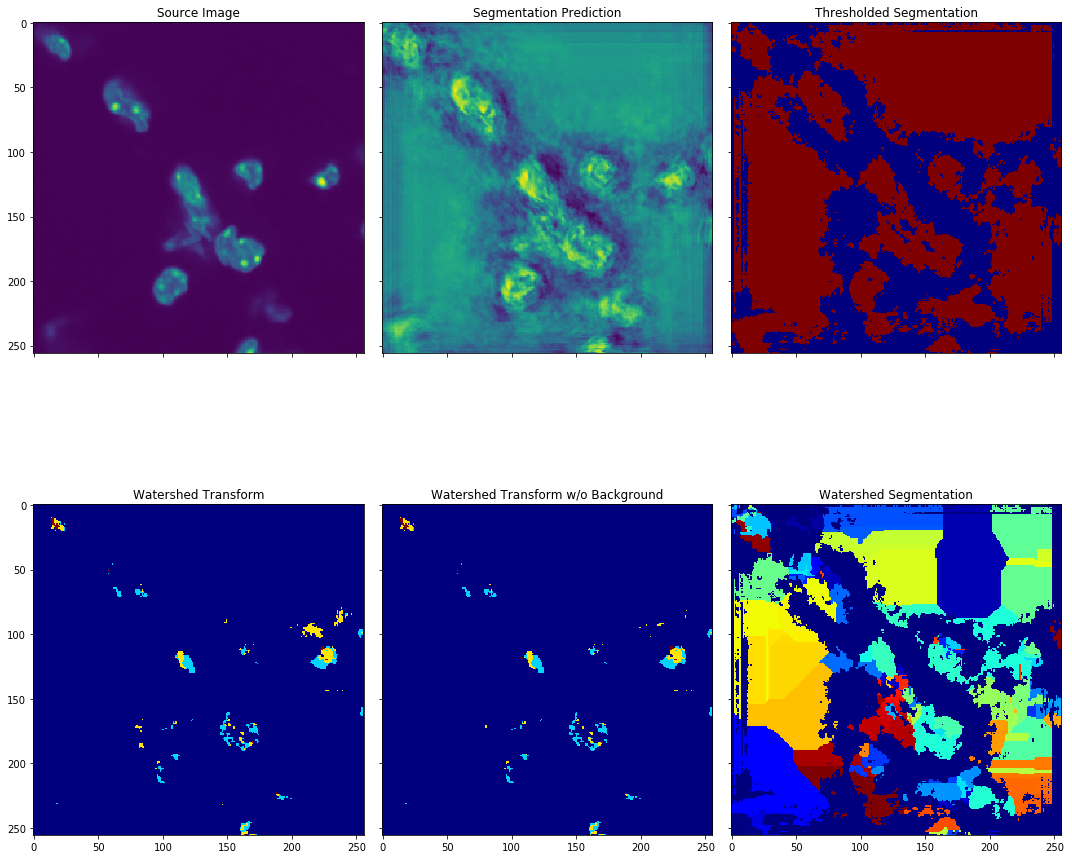

In [11]:
# Plot the results
import matplotlib.pyplot as plt
import matplotlib.animation as animation

index = 0
frame = 8

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, :, :, 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, frame, :, :, 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, frame, :, :, 0], cmap='jet')
ax[2].set_title('Thresholded Segmentation')

ax[3].imshow(argmax_images[index, frame, :, :, 0], cmap='jet')
ax[3].set_title('Watershed Transform')

ax[4].imshow(argmax_images_post_fgbg[index, frame, :, :, 0], cmap='jet')
ax[4].set_title('Watershed Transform w/o Background')

ax[5].imshow(watershed_images[index, frame, :, :, 0], cmap='jet')
ax[5].set_title('Watershed Segmentation')

fig.tight_layout()
plt.show()

# Sample Based Training

In [12]:
DATA_OUTPUT_MODE = 'sample'
PADDING = 'valid'
RESIZE = False
RESHAPE_SIZE = 256
NUM_FRAMES = 15
BINS = 8
EROSION = 3

# Set sample window size
WIN_X = 30
WIN_Y = 30
WIN_Z = 2

# filepath constants
DATA_DIR = '/data/data'
MODEL_DIR = '/data/models'
NPZ_DIR = '/data/npz_data'
RESULTS_DIR = '/data/results'
EXPORT_DIR = '/data/exports'
PREFIX = 'cells/MouseBrain/generic'
WATERSHED_DATA_FILE = 'MouseBrain_3d_watershed_{}_{}bins_{}erode_z{}'.format(
        DATA_OUTPUT_MODE, BINS, EROSION, WIN_Z)

FG_BG_DATA_FILE = 'MouseBrain_3d_{}'.format(DATA_OUTPUT_MODE)

# Check for channels_first or channels_last
IS_CHANNELS_FIRST = K.image_data_format() == 'channels_first'

ROW_AXIS = 3 if IS_CHANNELS_FIRST else 2
COL_AXIS = 4 if IS_CHANNELS_FIRST else 3
CHANNEL_AXIS = 1 if IS_CHANNELS_FIRST else 4

In [13]:
# Make the training data for foreground/background segmentation
make_training_data(
    dimensionality=3,
    direc_name=os.path.join(DATA_DIR, PREFIX),
    file_name_save=os.path.join(NPZ_DIR, PREFIX, FG_BG_DATA_FILE),
    channel_names=[''],  # for iterating over stacks of images from a montage
    training_direcs=None,  # use all training directories
    output_mode=DATA_OUTPUT_MODE,
    max_training_examples=None,
    window_size_x=WIN_X,
    window_size_y=WIN_Y,
    window_size_z=WIN_Z,
    padding=PADDING,
    reshape_size=None if not RESIZE else RESHAPE_SIZE,
    num_frames=NUM_FRAMES,
    montage_mode=True,  # annotation folder has montaged sub-dirs
    annotation_name='',  # basically channel name but for annotated images
    raw_image_direc='stacked_raw_parts',
    annotation_direc='annotated/all_montages')

if os.path.isfile(os.path.join(NPZ_DIR, PREFIX, FG_BG_DATA_FILE) + '.npz'):
    print('Data Saved to', os.path.join(NPZ_DIR, PREFIX, FG_BG_DATA_FILE) + '.npz')
else:
    raise Exception('Uh Oh!  Your data file did not save properly :(')

Data Saved to /data/npz_data/cells/MouseBrain/generic/MouseBrain_3d_sample.npz


In [14]:
# Make the training data for watershed distance transform
make_training_data(
    dimensionality=3,
    direc_name=os.path.join(DATA_DIR, PREFIX),
    file_name_save=os.path.join(NPZ_DIR, PREFIX, WATERSHED_DATA_FILE),
    channel_names=[''],  # for iterating over stacks of images from a montage
    training_direcs=None,  # use all training directories
    output_mode=DATA_OUTPUT_MODE,
    max_training_examples=None,
    window_size_x=WIN_X,
    window_size_y=WIN_Y,
    window_size_z=WIN_Z,
    padding=PADDING,
    reshape_size=None if not RESIZE else RESHAPE_SIZE,
    distance_transform=True,
    distance_bins=BINS,
    erosion_width=EROSION,
    num_frames=NUM_FRAMES,
    montage_mode=True,  # annotation folder has montaged sub-dirs
    annotation_name='',  # basically channel name but for annotated images
    raw_image_direc='stacked_raw_parts',
    annotation_direc='annotated/all_montages')

if os.path.isfile(os.path.join(NPZ_DIR, PREFIX, WATERSHED_DATA_FILE) + '.npz'):
    print('Data Saved to', os.path.join(NPZ_DIR, PREFIX, WATERSHED_DATA_FILE) + '.npz')
else:
    raise Exception('Uh Oh!  Your data file did not save properly :(')

Data Saved to /data/npz_data/cells/MouseBrain/generic/MouseBrain_3d_watershed_sample_8bins_3erode_z2.npz


In [15]:
# Load the training data from NPZ into a numpy array
training_data = np.load(os.path.join(NPZ_DIR, PREFIX, FG_BG_DATA_FILE + '.npz'))

X, y = training_data['X'], training_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

# Set up training parameters
n_epoch = 32
batch_size = 128
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.99)

X.shape: (220, 15, 256, 256, 1)
y.shape: (83655000,)


In [17]:
# First, create a foreground/background separation model

# Instantiate the model
fgbg_model = bn_feature_net_61x61_3D(
    n_features=2,
    n_frames=2 * WIN_Z + 1,
    n_channels=X.shape[CHANNEL_AXIS])

# Train the model
train_model_sample_movie(
    model=fgbg_model,
    dataset=FG_BG_DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    balance_classes=False,
    max_class_samples=1e6,
    n_epoch=n_epoch,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    expt='fgbg_no_balance',
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False)

X_train shape: (220, 15, 256, 256, 1)
y_train shape: (75289500,)
X_test shape: (220, 15, 256, 256, 1)
y_test shape: (8365500,)
Output Shape: (None, 2)
Number of Classes: 2
Using real-time data augmentation.
Epoch 1/32
15576/15577 [============================>.] - ETA: 0s - loss: 0.0637 - acc: 0.9297
Epoch 00001: val_loss improved from inf to 0.06207, saving model to /data/models/cells/MouseBrain/generic/2018-08-24_MouseBrain_3d_sample_fgbg_no_balance_0.h5
15577/15577 [==============================] - 4797s 308ms/step - loss: 0.0637 - acc: 0.9297 - val_loss: 0.0621 - val_acc: 0.9330
Epoch 2/32
15576/15577 [============================>.] - ETA: 0s - loss: 0.0604 - acc: 0.9335
Epoch 00002: val_loss improved from 0.06207 to 0.05936, saving model to /data/models/cells/MouseBrain/generic/2018-08-24_MouseBrain_3d_sample_fgbg_no_balance_0.h5
15577/15577 [==============================] - 4782s 307ms/step - loss: 0.0604 - acc: 0.9335 - val_loss: 0.0594 - val_acc: 0.9366
Epoch 3/32
 8243/1557

KeyboardInterrupt: 

In [18]:
# Load the training data from NPZ into a numpy array
training_data = np.load(os.path.join(NPZ_DIR, PREFIX, WATERSHED_DATA_FILE + '.npz'))

X, y = training_data['X'], training_data['y']
print('X.shape: {}\ny.shape: {}'.format(X.shape, y.shape))

# Set up training parameters
n_epoch = 32
batch_size = 128
optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=.99)

X.shape: (220, 15, 256, 256, 1)
y.shape: (83655000,)


In [ ]:
# Next, Create a model for the watershed energy transform

# Instantiate the model
watershed_model = bn_feature_net_61x61_3D(
    n_features=BINS,
    n_frames=2 * WIN_Z + 1,
    n_channels=X.shape[CHANNEL_AXIS])

# Train the model
train_model_sample_movie(
    model=watershed_model,
    dataset=WATERSHED_DATA_FILE,
    optimizer=optimizer,
    batch_size=batch_size,
    balance_classes=False,
    max_class_samples=1e6,
    n_epoch=n_epoch,
    direc_save=os.path.join(MODEL_DIR, PREFIX),
    direc_data=os.path.join(NPZ_DIR, PREFIX),
    expt='watershed_no_balance',
    lr_sched=lr_sched,
    rotation_range=180,
    flip=True,
    shear=False)

In [20]:
# With the trained models, make predictions on testing data
training_data_file = os.path.join(NPZ_DIR, PREFIX, CONV_DATA_FILE + '.npz')

train_dict, test_dict = get_data(
    training_data_file, mode='conv', seed=21)

X_test, y_test = test_dict['X'][:4], test_dict['y'][:4]

# Re-initializing dilated models for sample-mode predictions
watershed_weights_file = '2018-08-24_MouseBrain_3d_watershed_sample_8bins_3erode_z2_watershed_no_balance_0.h5'
watershed_weights_file = os.path.join(MODEL_DIR, PREFIX, watershed_weights_file)

fg_bg_weights_file = '2018-08-24_MouseBrain_3d_sample_fgbg_no_balance_0.h5'
fg_bg_weights_file = os.path.join(MODEL_DIR, PREFIX, fg_bg_weights_file)

run_watershed_model = dilated_bn_feature_net_61x61_3D(
    n_features=BINS,
    n_frames=2 * WIN_Z + 1,
    input_shape=X_test.shape[1:])
run_watershed_model.load_weights(watershed_weights_file)

run_fgbg_model = dilated_bn_feature_net_61x61_3D(
    n_features=2,
    n_frames=2 * WIN_Z + 1,
    input_shape=X_test.shape[1:])
run_fgbg_model.load_weights(fg_bg_weights_file)

In [21]:
# With the trained models, make predictions on testing data
test_images = run_watershed_model.predict(X_test[:4])
test_images_fgbg = run_fgbg_model.predict(X_test[:4])

print('watershed transform shape:', test_images.shape)
print('segmentation mask shape:', test_images_fgbg.shape)

argmax_images = []
for i in range(test_images.shape[0]):
    max_image = np.argmax(test_images[i], axis=CHANNEL_AXIS - 1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=CHANNEL_AXIS)

print('watershed argmax shape:', argmax_images.shape)

watershed transform shape: (4, 11, 196, 196, 8)
segmentation mask shape: (4, 11, 196, 196, 2)
watershed argmax shape: (4, 11, 196, 196, 1)


In [22]:
# threshold the foreground/background
# and remove back ground from watershed transform
threshold = 0.8
if IS_CHANNELS_FIRST:
    fg_thresh = test_images_fgbg[:, 1, :, :, :] > threshold
else:
    fg_thresh = test_images_fgbg[:, :, :, :, 1] > threshold

fg_thresh = np.expand_dims(fg_thresh, axis=CHANNEL_AXIS)
argmax_images_post_fgbg = argmax_images * fg_thresh

In [23]:
# Apply watershed method with the distance transform as seed
from scipy import ndimage
from skimage.morphology import watershed
from skimage.feature import peak_local_max

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    if IS_CHANNELS_FIRST:
        image = fg_thresh[i, 0, :, :, :]
        distance = argmax_images_post_fgbg[i, 0, :, :, :]
    else:
        image = fg_thresh[i, :, :, :, 0]
        distance = argmax_images_post_fgbg[i, :, :, :, 0]

    local_maxi = peak_local_max(
        distance,
        min_distance=20,
        indices=False,
        labels=image,
        exclude_border=False)

    markers = ndimage.label(local_maxi)[0]
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
watershed_images = np.expand_dims(watershed_images, axis=CHANNEL_AXIS)

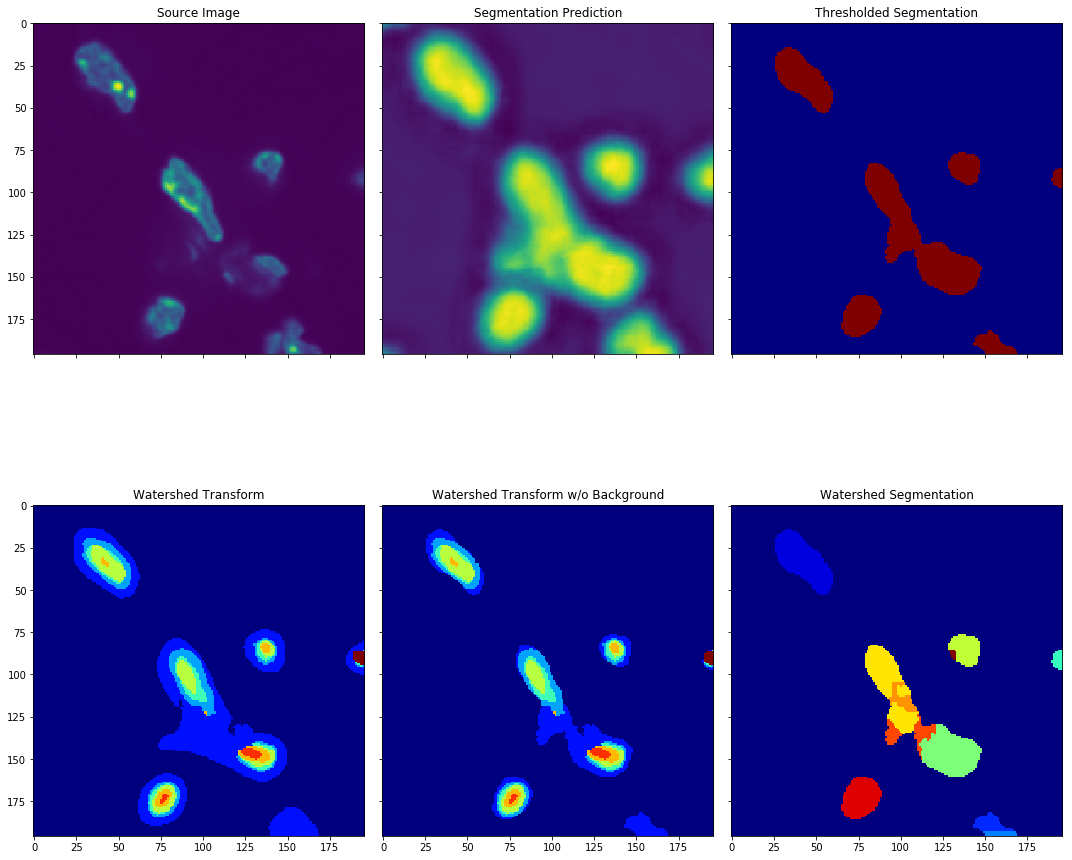

In [24]:
# Plot the results
import matplotlib.pyplot as plt

index = 0
frame = 5

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 15), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(X_test[index, frame, WIN_X:-WIN_X, WIN_Y:-WIN_Y, 0])
ax[0].set_title('Source Image')

ax[1].imshow(test_images_fgbg[index, frame, :, :, 1])
ax[1].set_title('Segmentation Prediction')

ax[2].imshow(fg_thresh[index, frame, :, :, 0], cmap='jet')
ax[2].set_title('Thresholded Segmentation')

ax[3].imshow(argmax_images[index, frame, :, :, 0], cmap='jet')
ax[3].set_title('Watershed Transform')

ax[4].imshow(argmax_images_post_fgbg[index, frame, :, :, 0], cmap='jet')
ax[4].set_title('Watershed Transform w/o Background')

ax[5].imshow(watershed_images[index, frame, :, :, 0], cmap='jet')
ax[5].set_title('Watershed Segmentation')

fig.tight_layout()
plt.show()

In [26]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def get_js_video(images, batch=0, channel=0, cmap='jet'):
    """Create a JavaScript video as HTML for visualizing 3D data as a movie"""
    fig = plt.figure()

    ims = []
    for i in range(images.shape[1]):
        im = plt.imshow(images[batch, i, :, :, channel], animated=True, cmap=cmap)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1000)
    return ani.to_jshtml()

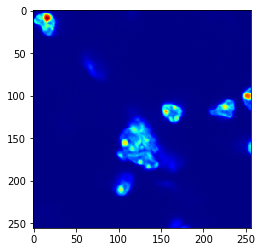

In [30]:
HTML(get_js_video(X_test, batch=0))

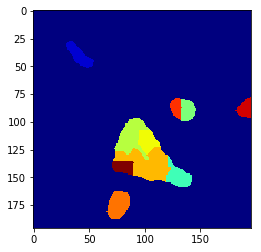

In [28]:
HTML(get_js_video(watershed_images, batch=0))

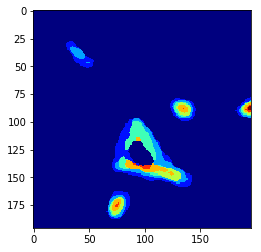

In [31]:
HTML(get_js_video(argmax_images_post_fgbg, batch=0))

In [ ]:
# Load the data to predict
from deepcell.utils.data_utils import load_training_images_3d

IMAGE_DIR = 'set1'

images = load_training_images_3d(
    direc_name=os.path.join(DATA_DIR, PREFIX),
    training_direcs=[IMAGE_DIR],
    channel_names=['DAPI'],
    raw_image_direc='raw',
    image_size=(1024, 1024),
    num_frames=30)

# Crop a bit of the original images, even 4 sub-images is too large
crop_size = 100
images = images[:, :, crop_size:-crop_size, crop_size:-crop_size, :]

# instantiate matrix for output of model
output = np.zeros(images.shape, dtype=K.floatx())

# Split the frames into quarters, as the full image size is too large
# Add WIN_X and WIN_Y so when it is cropped down we have the full image
crop_x = images.shape[ROW_AXIS] // 2
crop_y = images.shape[COL_AXIS] // 2

shape = (images.shape[ROW_AXIS - 1] - 2 * WIN_Z,
         2 * crop_x - WIN_X * 2,
         2 * crop_y - WIN_Y * 2)

if IS_CHANNELS_FIRST:
    fgbg_output = np.zeros((images.shape[0], 2, *shape), dtype=K.floatx())
    watershed_output = np.zeros((images.shape[0], BINS, *shape), dtype=K.floatx())
else:
    fgbg_output = np.zeros((images.shape[0], *shape, 2), dtype=K.floatx())
    watershed_output = np.zeros((images.shape[0], *shape, BINS), dtype=K.floatx())

img_0 = images[:, :, :crop_x + WIN_X, :crop_y + WIN_Y, :]
img_1 = images[:, :, :crop_x + WIN_X, crop_y - WIN_Y:, :]
img_2 = images[:, :, crop_x - WIN_X:, :crop_y + WIN_Y, :]
img_3 = images[:, :, crop_x - WIN_X:, crop_y - WIN_Y:, :]

watershed_weights_file = '2018-08-23_MouseBrain_3d_watershed_sample_8bins_3erode_z2_watershed_no_balance_0.h5'
watershed_weights_file = os.path.join(MODEL_DIR, PREFIX, watershed_weights_file)

fg_bg_weights_file = '2018-08-23_MouseBrain_3d_sample_fgbg_no_balance_0.h5'
fg_bg_weights_file = os.path.join(MODEL_DIR, PREFIX, fg_bg_weights_file)

run_watershed_model = dilated_bn_feature_net_61x61_3D(
    n_features=BINS,
    n_frames=2 * WIN_Z + 1,
    input_shape=img_0.shape[1:])
run_watershed_model.load_weights(watershed_weights_file)

run_fgbg_model = dilated_bn_feature_net_61x61_3D(
    n_features=2,
    n_frames=2 * WIN_Z + 1,
    input_shape=img_0.shape[1:])
run_fgbg_model.load_weights(fg_bg_weights_file)

fgbg_output[:, :, 0:crop_x - WIN_X, 0:crop_y - WIN_Y, :] = run_fgbg_model.predict(img_0)
fgbg_output[:, :, 0:crop_x - WIN_X, crop_y - WIN_Y:, :] = run_fgbg_model.predict(img_1)
fgbg_output[:, :, crop_x - WIN_X:, 0:crop_y - WIN_Y, :] = run_fgbg_model.predict(img_2)
fgbg_output[:, :, crop_x - WIN_X:, crop_y - WIN_Y:, :] = run_fgbg_model.predict(img_3)

watershed_output[:, :, 0:crop_x - WIN_X, 0:crop_y - WIN_Y, :] = run_watershed_model.predict(img_0)
watershed_output[:, :, 0:crop_x - WIN_X, crop_y - WIN_Y:, :] = run_watershed_model.predict(img_1)
watershed_output[:, :, crop_x - WIN_X:, 0:crop_y - WIN_Y, :] = run_watershed_model.predict(img_2)
watershed_output[:, :, crop_x - WIN_X:, crop_y - WIN_Y:, :] = run_watershed_model.predict(img_3)

# threshold the highest class
watershed_output[:,:,:,:,-1] = np.where(watershed_output[:,:,:,:,-1] < .2, 0, watershed_output[:,:,:,:,-1])

# Turn watershed output into argmax
argmax_images = []
for i in range(watershed_output.shape[0]):
    max_image = np.argmax(watershed_output[i], axis=CHANNEL_AXIS - 1)
    argmax_images.append(max_image)
argmax_images = np.array(argmax_images)
argmax_images = np.expand_dims(argmax_images, axis=CHANNEL_AXIS)

# Threshold the foreground/background
# and remove background from watershed transform
threshold = 0.8
if IS_CHANNELS_FIRST:
    thresh_output = fgbg_output[:, 1, :, :, :] > threshold
else:
    thresh_output = fgbg_output[:, :, :, :, 1] > threshold

thresh_output = np.expand_dims(thresh_output, axis=CHANNEL_AXIS)
argmax_images_post_fgbg = argmax_images * thresh_output

# Apply watershed method with the distance transform as seed
from scipy import ndimage
from skimage.morphology import watershed
from skimage.feature import peak_local_max

watershed_images = []
for i in range(argmax_images_post_fgbg.shape[0]):
    if IS_CHANNELS_FIRST:
        image = thresh_output[i, 0, :, :, :]
        distance = argmax_images_post_fgbg[i, 0, :, :, :]
    else:
        image = thresh_output[i, :, :, :, 0]
        distance = argmax_images_post_fgbg[i, :, :, :, 0]

    local_maxi = peak_local_max(
        distance,
        min_distance=20,
        indices=False,
        labels=image,
        exclude_border=False)

    markers = ndimage.label(local_maxi)[0]
    segments = watershed(-distance, markers, mask=image)
    watershed_images.append(segments)

watershed_images = np.array(watershed_images)
watershed_images = np.expand_dims(watershed_images, axis=CHANNEL_AXIS)

from skimage.external import tifffile as tiff

def save_output(output, name):
    out_dir = os.path.join(RESULTS_DIR, PREFIX, IMAGE_DIR, name)
    for b in range(output.shape[0]):
        for f in range(output.shape[1]):
            if K.image_data_format() == 'channels_first':
                feature = output[b, 0, f, :, :]
            else:
                feature = output[b, f, :, :, 0]
                cnnout_name = '{}_frame_{}.tif'.format(name, str(f).zfill(3))
                out_file_path = os.path.join(out_dir, cnnout_name)
                tiff.imsave(out_file_path, feature.astype('int32'))
    print('Saved {} {} frames to {}'.format(output.shape[1], name, out_dir))

save_output(images[:, WIN_Z:-WIN_Z], 'raw')
save_output(argmax_images_post_fgbg, 'argmax')
save_output(watershed_images, 'watershed')